Import dependencies, check GPU availability, and add RAFT/core to path

In [2]:
import os
import time
import sys
import numpy as np
import cv2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress import warnings
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict

sys.path.append('../RAFT/core') # Add to path
sys.path.append('../YOLO_UR5') # Add to path
# Add the parent directory of 'main' to the Python path
parent_dir = os.path.abspath(os.path.join(os.path.dirname('main.ipynb'), os.pardir))
sys.path.append(os.path.join(parent_dir, 'RAFT'))

from core.raft import RAFT
from core.utils import flow_viz
from core.utils.utils import InputPadder


print("Is torch.cuda Available? ", torch.cuda.is_available())
print("Device Count: ",torch.cuda.device_count())

if torch.cuda.is_available():
    curr_device = 'cuda'
    print("Device Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    curr_device = 'cpu'

# curr_dir = os.path.dirname(os.path.realpath(__file__))
# yolo_directory = os.path.join(curr_dir, 'YOLO_UR5')
# sys.path.add(yolo_directory)

# import YOLO


Is torch.cuda Available?  False
Device Count:  0


Define Helper Functions

In [3]:
def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(
        weights_path, map_location=torch.device(curr_device)) # Change to cuda if available
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to(curr_device) # Change to cuda if available
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel', iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
            flow_low, flow_up = model(frame1, frame2, iters=iters, flow_init=flow_init, upsample=upsample, test_mode=test_mode)
            return flow_low, flow_up

        else:
            flow_iters = model(frame1, frame2, iters=iters, flow_init=flow_init, upsample=upsample, test_mode=test_mode)
            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1, 2, 0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
    def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
        self.model = model
        self.path = path
        self.small = small
        self.mixed_precision = mixed_precision
        self.alternate_corr = alternate_corr

    """ Sketchy hack to pretend to iterate through the class objects """

    def __iter__(self):
        return self

    def __next__(self):
        raise StopIteration
    
# Converts pixel location (either matrix of pixels or single pixel) to tool frame coordinate system
def pix_to_pos(pixel_x, pixel_y, flow_x_matrix, image_center_x, image_center_y):

    # Declare stereo related variables
    baseline_x = 0.005
    tilt = np.radians(0) 
    focal_length = 891.77161 
    cam_x_offset = 0.000 
    cam_y_offset = 0.000
    pitch_angle = np.radians(0) 

    # Calculations
    world_conversion = baseline_x * np.cos(tilt) / flow_x_matrix # Calculating pixel to world conversion
    x_offsets = cam_x_offset - baseline_x # Including camera offset from center of gripper (if using a horizontal offset)
    x_translation_matrix = world_conversion * (image_center_x - pixel_x) # Calculating x translation using world conversion

    y_offsets = cam_y_offset
    pitch_offset = -((baseline_x * focal_length) / flow_x_matrix) * np.sin(pitch_angle) # Essentially using z-depth to find pitch offset
    y_translation_matrix = -world_conversion * (image_center_y - pixel_y) # Negated because camera is flipped upside down to match camera axes

    z_coord = ((baseline_x * focal_length) / -flow_x_matrix) # 2D matrix of depth values for each pixel in image
    # print(z_coord)
    x_coord = x_offsets - x_translation_matrix # 2D matrix of x-coordinate values for each pixel in image
    y_coord = pitch_offset + y_offsets + y_translation_matrix # 2D matrix of y-coordinate values for each pixel in image

    # Tuning matrix by getting rid of negative depths and zeros and make them infinity
    z_coord = np.where(z_coord <= 0, np.inf, z_coord) 

    return x_coord, y_coord, z_coord

Run YOLO on Images to Identify Blackberries

In [4]:
# %matplotlib inline
# annotated_image_1, berry_centroids_1 = YOLO.apply_yolo_to_image('2.5mm_1.png')
# annotated_image_2, berry_centroids_2 = YOLO.apply_yolo_to_image('2.5mm_2.png')

# # print(berry_centroids_1)
# # print(berry_centroids_2)

# # print(annotated_image_1.shape)
# # print(annotated_image_2.shape)

# image_center_x = annotated_image_1.shape[1] / 2
# image_center_y = annotated_image_1.shape[0] / 2

# # print(image_center_x)
# # print(image_center_y)

# frame_1_centroid_x = berry_centroids_1[:, 0]
# frame_1_centroid_y = berry_centroids_1[:, 1]

# # print(frame_1_centroid_x)
# # print(frame_1_centroid_y)

# x_disparity = np.abs(berry_centroids_2 - berry_centroids_1)[:, 0]

# # print(x_disparity)

# # berry1_x = frame_1_centroid_x[0]
# # berry1_y = frame_1_centroid_y[0]

# berries_x_pos, berries_y_pos, berries_z_pos = pix_to_pos(frame_1_centroid_x, frame_1_centroid_y, x_disparity, image_center_x, image_center_y)
# berries_pos_matrix = np.column_stack((berries_x_pos, berries_y_pos, berries_z_pos))
# print("Berry Positions (m): ")
# print(berries_pos_matrix)

# fig, axes = plt.subplots(1, 2, figsize=(15, 10))
# axes[0].imshow(annotated_image_1)
# axes[0].set_title('YOLO Berry Detection - Image 1')
# axes[1].imshow(annotated_image_2)
# axes[1].set_title('YOLO Berry Detection - Image 2')
# plt.tight_layout()
# plt.show()

Run Model on Desired Images

In [5]:
model = load_model("../RAFT/models/raft-sintel.pth", args=Args())
frame1 = cv2.imread('Frame1_5mm.png')
frame2 = cv2.imread('Frame2_5mm.png')

# Downsample image to reduce computation complexity (using Lanczos4 downsampling algorithm)
frame1 = cv2.resize(frame1, (320, 240), interpolation=cv2.INTER_LANCZOS4)
frame2 = cv2.resize(frame2, (320, 240), interpolation=cv2.INTER_LANCZOS4)

# Convert images to rgb color space
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

# Resize the second image to match the dimensions of the first image
height, width, channels = frame2.shape
frame1 = cv2.resize(frame1, (width, height))

# Apply RAFT Optical Flow Model on Frame 1 and 2
time1 = time.perf_counter()
flow_iters = inference(model, frame1, frame2, device=curr_device, iters=5, test_mode=False)
time2 = time.perf_counter()
print("Inference Time: ", time2 - time1)

/Users/alex/miniconda3/envs/GRIP_env/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/alex/miniconda3/envs/GRIP_env/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646755922314/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Inference Time:  3.533855422000215


Visualizing Model Inference for Optical Flow from Frame 1 to Frame 2

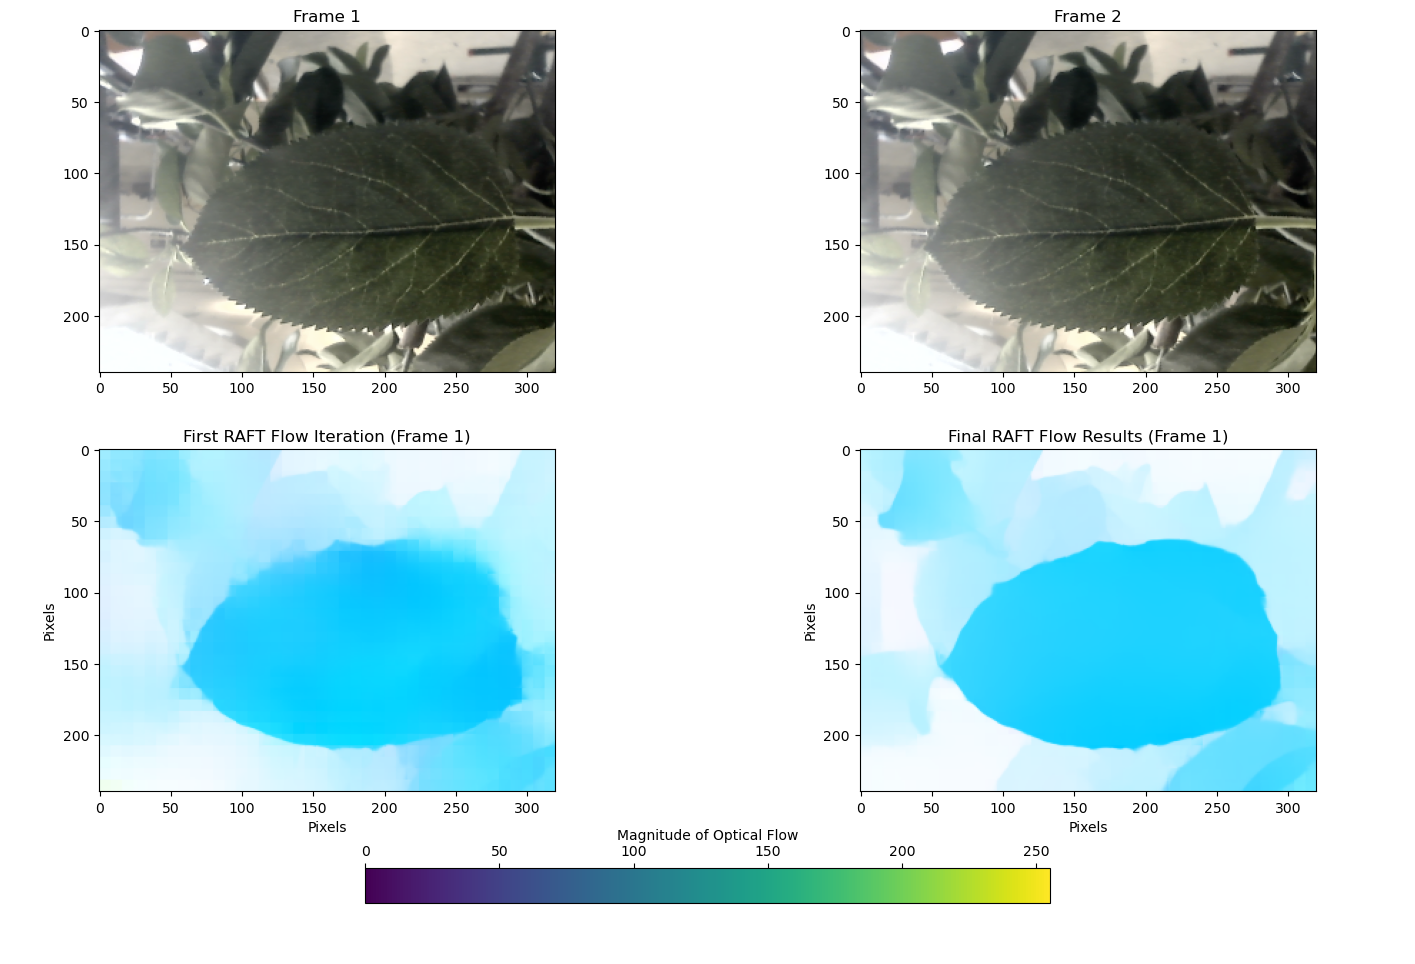

In [6]:
%matplotlib inline
fig2, axes = plt.subplots(3, 2, figsize=(18, 12), gridspec_kw={'height_ratios': [4, 4, 1]})
fig2.subplots_adjust(hspace=0.3)
axes[0, 0].imshow(frame1)
axes[0, 0].set_title("Frame 1")
axes[0, 1].imshow(frame2)
axes[0, 1].set_title("Frame 2")

first_flow_viz = axes[1, 0].imshow(get_viz(flow_iters[0]))
axes[1, 0].set_title('First RAFT Flow Iteration (Frame 1)')
axes[1, 0].set_xlabel("Pixels"); axes[1, 0].set_ylabel("Pixels")
final_flow_viz = axes[1, 1].imshow(get_viz(flow_iters[-1]))
axes[1, 1].set_title('Final RAFT Flow Results (Frame 1)')
axes[1, 1].set_xlabel("Pixels"); axes[1, 1].set_ylabel("Pixels")

# Add color bars
axes[2, 0].axis('off'); axes[2, 1].axis('off')
cbar0 = fig2.colorbar(first_flow_viz, ax=axes[2, :], fraction=0.4, pad=0.04, location="top")
cbar0.set_label('Magnitude of Optical Flow')
plt.show()

Final Iteration Flow Analysis

In [7]:
# Retrieve final flow iteration and the corresponding flow tensors for x and y
final_flow = flow_iters[-1]
flow_x_matrix = final_flow[0, 0]  # Horizontal displacement component in pixels
flow_y_matrix = final_flow[0, 1]  # Vertical displacement component in pixels

# Compute the magnitude of flow
flow_magnitude = torch.sqrt(flow_x_matrix**2 + flow_y_matrix**2)

# Convert flow tensors to numpy arrays and round all points to 4 decimal places
flow_x_matrix = np.round(flow_x_matrix.cpu().numpy(), decimals=4) # Tensor to numpy array can only be done on CPU
flow_y_matrix = np.round(flow_y_matrix.cpu().numpy(), decimals=4)
flow_magnitude = np.round(flow_magnitude.cpu().numpy(), decimals=4)

np.savetxt('flow_x_matrix.txt', flow_x_matrix)
np.savetxt('flow_y_matrix.txt', flow_y_matrix)
np.savetxt('flow_magnitude.txt', flow_magnitude)

# Extra Information
max_index = np.unravel_index(np.argmax(flow_x_matrix, axis=None), flow_x_matrix.shape)
print("Index of maximum flow-x value:", max_index)
baseline_x = 0.005
tilt = np.radians(0) 
print("Maximum Flow in x-direction :", np.max(flow_x_matrix), "pixels")
print("Minimum Flow in x-direction :", np.min(flow_x_matrix), "pixels")

# Calculating pixel to world conversion
world_conversion = baseline_x * np.cos(tilt) / np.max(flow_x_matrix) 
print("Pixels per mm at the depth where max disparity is: ", (1 / world_conversion) / 1000)

Index of maximum flow-x value: (8, 288)
Maximum Flow in x-direction : -0.343 pixels
Minimum Flow in x-direction : -15.8923 pixels
Pixels per mm at the depth where max disparity is:  -0.06859999895095825


Apply Flow Threshold

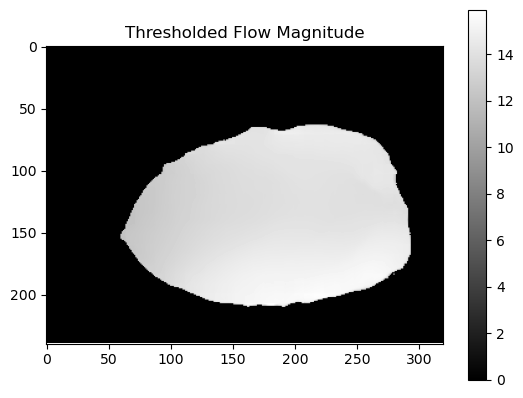

In [8]:
# Apply threshold to flow magnitude
flow_threshold = 12  # Pixel displacement threshold value
flow_magnitude_filtered = np.where(flow_magnitude < flow_threshold, 0, flow_magnitude) # New matrix of pixels that turn black (value set to 0) if not passing flow threshold
removed_indices = np.where(flow_magnitude_filtered == 0)

# Visualize the thresholded flow magnitude
plt.imshow(flow_magnitude_filtered, cmap='gray')
plt.title('Thresholded Flow Magnitude')
plt.colorbar()
plt.show()

# Adjust Flow matrices so that the filtered out pixels are set to infinity so they can be ignored for later processing
flow_x_matrix[removed_indices] = np.inf
flow_y_matrix[removed_indices] = np.inf

# Creating Matrix of Pixels
height, width, channels = final_flow_viz.get_array().shape

# Create arrays representing the x and y coordinates of pixels
x_coords = np.tile(np.arange(width), height)
y_coords = np.repeat(np.arange(height), width)

# Reshape x_coords and y_coords to match the shape of the image
x_coords = x_coords.reshape(height, width)
y_coords = y_coords.reshape(height, width)

# Stack x_coords and y_coords to create the matrix of pixels
pixel_matrix = np.dstack((x_coords, y_coords))
x_pix_matrix = pixel_matrix[:, :, 0]
y_pix_matrix = pixel_matrix[:, :, 1]

# print("X Pixel Matrix Shape: ", x_pix_matrix.shape)
# print("Y Pixel Matrix Shape: ", y_pix_matrix.shape)

X, Y, Z Location of Each Pixel in Frame 1 with Respect to Tool Frame

In [9]:
# Get matrices of (x, y, z) locations for each pixel in image
im_center_x = final_flow[0][0].shape[1] / 2
print(im_center_x)
im_center_y = final_flow[0][0].shape[0] / 2 
print(im_center_y)
x_pos_matrix, y_pos_matrix, z_pos_matrix = pix_to_pos(x_pix_matrix, y_pix_matrix, flow_x_matrix, im_center_x, im_center_y) 
print(z_pos_matrix.shape)
kept_indices = np.where(np.isfinite(z_pos_matrix))

x_pos_filtered = x_pos_matrix[kept_indices]
y_pos_filtered = y_pos_matrix[kept_indices]
z_pos_filtered = z_pos_matrix[kept_indices]     
obstacle_3d_points = np.column_stack((x_pos_filtered, y_pos_filtered, z_pos_filtered))

print("Obstacle Points Shape: ", obstacle_3d_points.shape)

print("\nMaximum finite x value (m): ", np.round(np.max(x_pos_matrix[np.isfinite(x_pos_matrix)]), decimals=4))
print("Minimum x value (m): ", np.round(np.min(x_pos_matrix), decimals=4))

print("\nMaximum finite y value (m): ", np.round(np.max(y_pos_matrix[np.isfinite(y_pos_matrix)]), decimals=4))
print("Minimum y value (m): ", np.round(np.min(y_pos_matrix), decimals=4))

print("\nMaximum finite z value (m): ", np.round(np.max(z_pos_matrix[np.isfinite(z_pos_matrix)]), decimals=4))
print("Minimum depth value (m): ", np.round(np.min(z_pos_matrix), decimals=4))

160.0
120.0
(240, 320)
Obstacle Points Shape:  (26452, 3)

Maximum finite x value (m):  0.0367
Minimum x value (m):  -0.0586

Maximum finite y value (m):  0.0231
Minimum y value (m):  -0.0362

Maximum finite z value (m):  0.3715
Minimum depth value (m):  0.2806


Plotting point cloud

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as subplots
import plotly.graph_objects as go

# Create 3D point cloud plot using plotly
fig_3d = px.scatter_3d(x=x_pos_filtered, y=y_pos_filtered, z=z_pos_filtered, color=z_pos_filtered,
                            opacity=1, size_max=5, color_continuous_scale='Viridis')
fig_3d.update_layout(title='3D Point Cloud', coloraxis_colorbar=dict(title='Z_Depth Magnitude'), width=1000, height=500)
fig_3d.show()

# fig_2d = px.scatter(x=x_pos_filtered, y=y_pos_filtered)
# fig_2d.update_layout(title='XY View of Point Cloud')
# fig_2d.show()



Save Point Cloud Information to File

In [11]:
# Save as .ply point cloud file
import open3d as o3d

pcd = o3d.geometry.PointCloud()
points = o3d.utility.Vector3dVector(obstacle_3d_points) # Convert numpy array to Open3D Vector
pcd.points = points
o3d.io.write_point_cloud("obstacle_point_cloud.ply", pcd)

# Save as .txt file
np.savetxt('point_cloud_txt.txt', obstacle_3d_points)

In [ ]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
points = o3d.utility.Vector3dVector(obstacle_3d_points) # Convert numpy array to Open3D Vector
pcd.points = points

voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=0.001)

# # Set up view control parameters without creating a window
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name='Open3D', width=800, height=600)

# # Add voxel grid to the visualization
# vis.add_geometry(voxel_grid)

# # Get the view control parameters
# ctr = vis.get_view_control()

# # Set axes visible
# ctr.axes_visibility = True

# # Set axis labels
# ctr.axes_label_visibility = True

# # Set size of the visualization window
# vis.get_render_option().point_size = 3

# # Keep the window open until it is manually closed
# vis.run()
o3d.visualization.draw_geometries([voxel_grid])

Creating Voxel Grid Using Open3D Library

In [ ]:
# import open3d as o3d
# import os

# # Parameters class holding variables that change in the callback function
# class Params:
#     # counter for selecting a new voxel size
#     sizes_counter = 0
#     # array of voxel sizes between 0.01 and 0.1
#     voxel_sizes = np.arange(0.001)
#     # empty TriangleMesh object that will contain the cubes
#     vox_mesh = o3d.geometry.TriangleMesh()
#     # boolean value used for initial initialization of the voxel mesh
#     initialize = True

# # Callback function used to construct and rotate the voxel meshes
# def rotate_and_change(vis):
#     # When the sizes_counter is 0 generate the voxel grid and construct the voxel mesh
#     if Params.sizes_counter == 0:
#         # generate the voxel grid using the voxel sizes setup in the params class
#         voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=Params.voxel_sizes[Params.sizes_counter])
#         # get all voxels in the voxel grid
#         voxels_all = voxel_grid.get_voxels()
#         # get the calculated size of a voxel
#         voxel_size = voxel_grid.voxel_size
#         # loop through all the voxels
#         for voxel in voxels_all:
#             # create a cube mesh with a size 1x1x1
#             cube = o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
#             # paint it with the color of the current voxel
#             cube.paint_uniform_color(voxel.color)
#             # scale the box using the size of the voxel
#             cube.scale(voxel_size, center=cube.get_center())
#             # get the center of the current voxel
#             voxel_center = voxel_grid.get_voxel_center_coordinate(voxel.grid_index)
#             # translate the box to the center of the voxel
#             cube.translate(voxel_center, relative=False)
#             # add the box to the TriangleMesh object
#             Params.vox_mesh += cube

#         # on the first run of the callback loop initialize the Triangle mesh by adding it to the Visualizer. In subsequent iterations just update the geometry
#         if Params.initialize:
#             vis.add_geometry(Params.vox_mesh)
#             Params.initialize = False
#         else:
#             vis.update_geometry(Params.vox_mesh)

#     vis.update_renderer()

# # Initialize a point cloud object
# pcd = o3d.geometry.PointCloud()

# # Add the points, colors and normals as Vectors
# pcd.points = o3d.utility.Vector3dVector(obstacle_3d_points)
# # pcd.colors = o3d.utility.Vector3dVector(colors)
# # pcd.normals = o3d.utility.Vector3dVector(normals)

# # Initialize a visualizer object
# vis = o3d.visualization.Visualizer()

# # Create a window, name it and scale it
# vis.create_window(window_name="Obstacle Visualization", width=1000, height=800)

# # Add the point cloud and create a 3D axis for reference
# vis.add_geometry(pcd)
# vis.add_geometry(o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1))

# # # Create text annotations for the axis labels
# # x_label = o3d.geometry.TriangleMesh.create_text("X", 10, 1, False, False)
# # y_label = o3d.geometry.TriangleMesh.create_text("Y", 10, 1, False, False)
# # z_label = o3d.geometry.TriangleMesh.create_text("Z", 10, 1, False, False)

# # # Position the labels along the axes
# # x_label.translate([1.1, 0, 0])  # Position the X label along the X-axis
# # y_label.translate([0, 1.1, 0])  # Position the Y label along the Y-axis
# # z_label.translate([0, 0, 1.1])  # Position the Z label along the Z-axis

# # Register the callback function
# vis.register_animation_callback(rotate_and_change)

# # We run the visualizer
# vis.run()

# # Once the visualizer is closed destroy the window and clean up
# vis.destroy_window()
